# Recurrent Neural Networks

Notes on RNNs:
---
- Model temporal dependencies in time-series data
- Multiple architectural extensions: LSTM, Uni-directional, bi-directional 
- Trained using Backpropagation and optimization algorithm, e.g. Gradient descent
- Implemented in most Neural Networks libraries

# Time-series data

![](resources/time_series_data.png)
![](resources/ts.png)

# The most basic model

![](resources/rnn_architecture.png)

Source: https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

- $a^{<t>}=f_1(W_{aa}a^{<t-1>}+W_{ax}x^{t}+b_y)$
- $y^{<t>}=f_2(W_{ya}a^{<t>}+b_y)$
- $x^{<t>}:=\begin{bmatrix} x^{<t>}_1  \\ ... \\ x^{<t>}_{N_B} \end{bmatrix}$, is the t-th timestep value of all N points in batch $B$. 
- For both curves in the above plot we ould have: $x^{<t>}:=\begin{bmatrix} x^{<t>}_1  \\  x^{<t>}_{2} \end{bmatrix}$ at a specified point on the x-axis.
- We do not have to make predictions $y^{<t>}$ at every timestep, but can unstead decide to make predictions only after 2,3,4 ... etc. timesteps.

[Very recommended Cheatsheet for RNNs and CNNs](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks)

![](https://www.researchgate.net/profile/Sergio_Guadarrama/publication/319770438/figure/fig1/AS:613925582303265@1523382673457/A-diagram-of-a-basic-RNN-cell-left-and-an-LSTM-memory-cell-right-used-in-this-paper.png)

# PyTorch Implementation

### 0. Do the imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler

### 1. Load and preprocess the data

In [2]:
# Importing the training set
dataset_train = pd.read_csv('data/Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1)) 
training_set_scaled = sc.fit_transform(training_set)

In [40]:
dataset_train.head(3)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"


In [68]:
dataset_train.tail(3)

,Date,Open,High,Low,Close,Volume
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"
1257,12/30/2016,782.75,782.78,770.41,771.82,"1,770,000"


In [41]:
dataset_train.shape

(1258, 6)

In [43]:
training_set.shape # Open 열

(1258, 1)

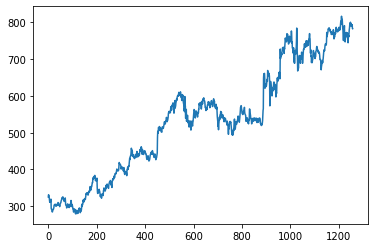

In [5]:
plt.plot(training_set)

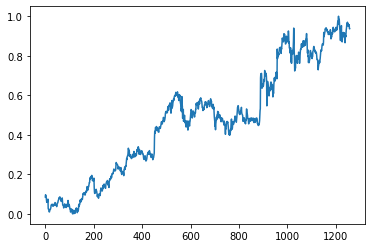

In [6]:
plt.plot(training_set_scaled)

In [45]:
INPUT_SIZE = 60
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1

In [46]:
# Creating a data structure with 60 timesteps and 1 output
# 60 타임스텝마다 아웃풋은 1번만
X_train = []
y_train = []

for i in range(INPUT_SIZE, 1258):
    # i : 60~1257
    X_train.append(training_set_scaled[i-INPUT_SIZE:i, 0])
    # [60-60:60, 0] == [0:60,0]
    # 0~59 입력
    y_train.append(training_set_scaled[i, 0])
    # [60,0]
    # 60 출력
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# (a, b) -> (a, 1, b)

In [48]:
# 만약 i가 62라면 X_train은
training_set_scaled[62-60:62,0].shape

(60,)

In [49]:
# 만약 i가 61이라면 y_train은
training_set_scaled[61,0]

0.08471612471166012

In [50]:
X_train.shape

(1198, 1, 60)

In [52]:
X_train[0].shape

(1, 60)

In [53]:
X_train[1].shape

(1, 60)

In [54]:
X_train[0][0].shape

(60,)

In [57]:
X_train[5][0].shape

(60,)

### 2. Implement the model

In [58]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()
        
        self.rnn = torch.nn.RNN(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x):
        
        r_out, hidden_state = self.rnn(x)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        
        outs = self.out(r_out)
        
        return outs, hidden_state

In [59]:
rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)

In [60]:
rnn

RNN(
  (rnn): RNN(60, 64, num_layers=2)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

### 3. Train the model

In [61]:
# 하이퍼파라미터들
learning_rate = 0.01
num_epochs = 50

In [62]:
# 최적화/지표
optimiser = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [63]:
# import sys

In [64]:
hidden_state = None

for epoch in range(num_epochs):
    inputs = torch.from_numpy(X_train).float()
    labels = torch.from_numpy(y_train).float()

    optimiser.zero_grad()
    
    # model
    output, hidden_state = rnn(inputs) 
    
    loss = criterion(output.view(-1), labels)
    
    loss.backward(retain_graph=True)                     
    optimiser.step()                                     
    
    print('epoch {}, loss {}'.format(epoch,loss.item()))

epoch 0, loss 0.20955443382263184
epoch 1, loss 0.12114471942186356
epoch 2, loss 0.07119861990213394
epoch 3, loss 0.0433189757168293
epoch 4, loss 0.028016645461320877
epoch 5, loss 0.019743412733078003
epoch 6, loss 0.015311403200030327
epoch 7, loss 0.01293615810573101
epoch 8, loss 0.011644206009805202
epoch 9, loss 0.010916047729551792
epoch 10, loss 0.010479257442057133
epoch 11, loss 0.010192840360105038
epoch 12, loss 0.009984541684389114
epoch 13, loss 0.009817562066018581
epoch 14, loss 0.009673241525888443
epoch 15, loss 0.009542129002511501
epoch 16, loss 0.009419421665370464
epoch 17, loss 0.00930265337228775
epoch 18, loss 0.009190542623400688
epoch 19, loss 0.009082396514713764
epoch 20, loss 0.008977814577519894
epoch 21, loss 0.008876550011336803
epoch 22, loss 0.008778427727520466
epoch 23, loss 0.008683321066200733
epoch 24, loss 0.00859111174941063
epoch 25, loss 0.008501702919602394
epoch 26, loss 0.008415000513195992
epoch 27, loss 0.008330915123224258
epoch 28, 

### 4. Evaluate the model

In [65]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv('data/Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [66]:
dataset_test.shape

(20, 6)

In [73]:
len(dataset_test)

20

In [67]:
dataset_test.head(3)

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"


In [69]:
# Getting the predicted stock price of 2017
# train은 2016까지 데이터
# test는 2017부터 데이터
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

In [70]:
dataset_total.shape

(1278,)

In [71]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - INPUT_SIZE:].values
# [1278 - 20 - 60:] = [1198:]
# 1278 total
# 1258 train
# 20 test
# 60 input size

In [72]:
inputs.shape

(80,)

In [96]:
# 처음 나올 아웃풋
dataset_test.iloc[0,:]["Open"] == dataset_total.iloc[-20]

True

In [97]:
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [98]:
inputs.shape

(80, 1)

In [99]:
X_test = []
for i in range(INPUT_SIZE, 80):
    # i : 60~79
    X_test.append(inputs[i-INPUT_SIZE:i, 0])
    # [60-60:60, 0] == [0:60, 0]
X_test = np.array(X_test)

In [100]:
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [101]:
X_test.shape

(20, 1, 60)

In [102]:
X_train_X_test = np.concatenate((X_train, X_test),axis=0)

In [103]:
X_train_X_test.shape # 1278(total) - 60(input_size) = 1218

(1218, 1, 60)

In [104]:
test_inputs = torch.from_numpy(X_train_X_test).float()
# model prediction
predicted_stock_price, h = rnn(test_inputs)

In [105]:
test_inputs.shape

torch.Size([1218, 1, 60])

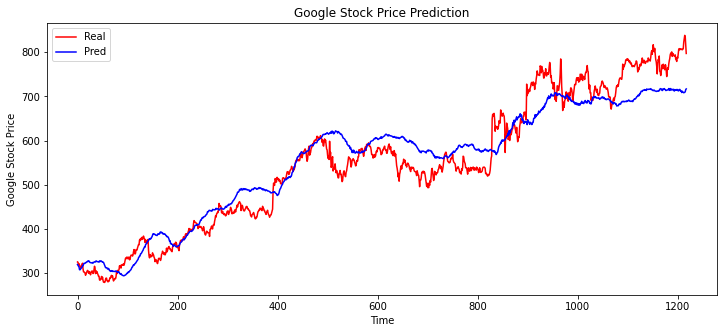

In [106]:
predicted_stock_price = np.reshape(predicted_stock_price.detach().numpy(), (test_inputs.shape[0], 1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

real_stock_price_all = np.concatenate((training_set[INPUT_SIZE:], real_stock_price))

# Visualising the results
plt.figure(1, figsize=(12, 5))
plt.plot(real_stock_price_all, color = 'red', label = 'Real')
plt.plot(predicted_stock_price, color = 'blue', label = 'Pred')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()